In [2]:
import os
import clip.clip as clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import json
import pandas as pd
from torchvision import transforms
from PIL import Image

In [3]:
1+1

2

In [4]:
#model loading
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(device)
model, preprocess = clip.load('/data/datasets/Epickitchens100_clips/ViT-B-16.pt', device)

cuda:1


In [5]:
# load annotations
# one is noun another is noun_id
annotations = pd.read_csv('./EPIC_100_noun_classes.csv', delimiter=',')
verb_anno=pd.read_csv('./EPIC_100_verb_classes.csv',delimiter=',')
nouns = list(annotations.values[:, 1])
nouns_id = list(annotations.values[:,0])
verbs=list(verb_anno["key"])


In [6]:
#! Device Check
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda:1
Current cuda device: 0
Count of using GPUs: 2


In [7]:

class EPICK_center(Dataset):
    def __init__(self, data_path,anno_path, transform=None, target_transform=None):
        super(EPICK_center, self).__init__()
        self.data_path = data_path
        self.anno_path = anno_path
        self.transform = transform
        self.target_transform= target_transform
        import pandas as pd
        annotations = pd.read_csv(self.anno_path, header=None, delimiter=',')
        self.img_name = list(annotations.values[:, 0])# name
        self.noun_labels= list(annotations.values[:,2])# noun
        self.verb_labels = list(annotations.values[:,1])#verb
        self.transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    ])

        self.target_transform = transforms.Compose([
            transforms.Resize((224, 224)),      # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
        ])
        
    def __len__(self):
        return len(self.noun_labels)
    
    def __getitem__(self, idx):
        # file 경로
        img_path     = self.img_name[idx] + '.jpg'
        full_path    = os.path.join(self.data_path, img_path)
        # torchvision로 이미지 로드
        # image = read_image(full_path)
        image = Image.open(full_path)
        noun_label = self.noun_labels[idx]
        verb_label = self.verb_labels[idx]
        # transform 적용
        if self.transform:
            image = self.transform(image)
        # if self.target_transform:
        #     image = self.target_transform(image)
        # image, label return
        return image, noun_label,verb_label, full_path


In [8]:
Epick_datasets=EPICK_center('/local_datasets/Epickitchens100_clips_center/images/','./epic/epic100_total.csv',transform=True)
len(Epick_datasets)

76885

In [9]:

text_inputs = torch.cat([clip.tokenize(f"a photo of pepole holding {c}") for c in nouns]).to(device)
# f"First-person photo of interacting with {c} in the kitchen"
# 2979
# 3.87461793587826
# "First-person photo of interacting with {c}
# 3193
# 4.152955713077974

# One sample Test code

The sample is about
noun:[nut]
verb:[pour]
id: 133


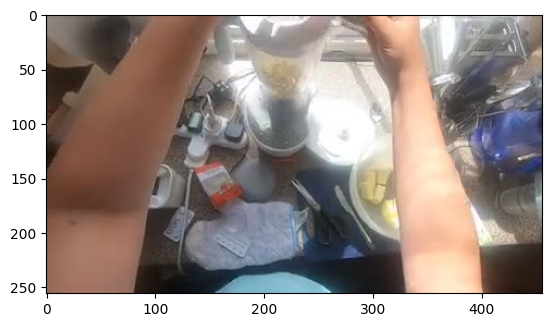


Top predictions:

         blender: 12.94%
          juicer: 11.07%
  liquid:washing: 4.84%
machine:sous:vide: 4.20%
 machine:washing: 3.95%


In [10]:
sample=Epick_datasets[50000]
print(f"The sample is about\nnoun:[{nouns[sample[1]]}]\nverb:[{verbs[sample[2]]}]")
print(f"id: {sample[1]}")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(sample[3])
plt.imshow(img)
plt.show()
image_input = sample[0].unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{nouns[index]:>16s}: {100 * value.item():.2f}%")

In [17]:
image_template=[
    'a fisrt person picture of acting with {}.',
    'A picture of someone with {}.',
    'A person holding {}.',
    'A shot of {}.',
    'A person is holding {} in their hand.',
    'A person is using {} to create something.',
    'A person is interacting with {}.',
]

# All sample Test Code

In [18]:
import random
text_inputs = torch.cat([clip.tokenize(
    # f"person is using {c}."
    random.choice(image_template).format(c)
    ) for c in nouns]).to(device)
correct=0
#Loader
Epick_dataloader=DataLoader(Epick_datasets,400,num_workers=12, shuffle=False)
with torch.no_grad():
    '''
    similarity : (B, num_noun)
    topk : The number you want to see top rank.
    If topk(r) , r>1 . you redefine acc metric code.
    '''
    for a in Epick_dataloader:
        data=a[0]
        label=a[1]#noun
        image_features = model.encode_image(data.to(device))
        text_features = model.encode_text(text_inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity.topk(1)
        
        # If topk(r) , r>1 . you redefine acc metric code.
        for i,k in enumerate(indices):
            pred=list(k)# k is 1-d tensor, label[i] is 1d list
            if pred[0]==label[i]:
                correct+=1
acc=correct/len(Epick_datasets)
print(acc)
with open('./result_epic.txt', 'a') as f:
    f.write("\nperson is using {c}.")
    f.write(f"\n\t{format(acc*100, '.2f')}%")




0.02862717044937244
